# Mini-project 1: Deep Q-learning for Epidemic Mitigation

## Imports

In [1]:
"""Environment imports"""
from epidemic_env.agent import Agent
from epidemic_env.dynamics import ModelDynamics
from epidemic_env.env import Env

"""Pytorch and numpy imports"""
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import numpy as np

#@formatter:off
%matplotlib inline
#@formatter:on

import os
#os.environ['CUBLAS_WORKSPACE_CONFIG'] = ":4096:8"

c:\Users\anton\AppData\Local\Programs\Python\Python39\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
# detect the device (CPU or GPU)
device = 'cuda:0' if torch.cuda.is_available() else 'cpu'
print(device)
device = torch.device(device)


cuda:0


In [3]:
def plot_results(total, actions, cities):
    fig = plt.figure(figsize=(14, 10))
    ax_leftstate = plt.subplot2grid(shape=(9, 2), loc=(0, 0), rowspan=4)
    ax_leftobs = plt.subplot2grid(shape=(9, 2), loc=(4, 0), rowspan=3)
    ax_leftactions = plt.subplot2grid(shape=(9, 2), loc=(7, 0), rowspan=2)
    ax_right = [plt.subplot2grid(shape=(9, 2), loc=(0, 1), colspan=1)]
    ax_right += [plt.subplot2grid(shape=(9, 2), loc=(i, 1), colspan=1) for i in range(1, 9)]
    ax_right = {k: ax_right[_id] for _id, k in enumerate(cities.keys())}

    [ax_leftstate.plot(y) for y in total.values()]
    ax_leftstate.legend(total.keys())
    ax_leftstate.set_title('Full state')
    ax_leftstate.set_ylabel('number of people in each state')

    [ax_leftobs.plot(total[y]) for y in ['infected', 'dead']]
    ax_leftobs.legend(['infected', 'dead'])
    ax_leftobs.set_title('Observable state')
    ax_leftobs.set_ylabel('number of people in each state')

    ax_leftactions.imshow(np.array([v for v in actions.values()]).astype(np.uint8), aspect='auto')
    ax_leftactions.set_title('Actions')
    ax_leftactions.set_yticks([0, 1, 2, 3])
    ax_leftactions.set_yticklabels(list(actions.keys()))
    ax_leftactions.set_xlabel('time (in weeks)')

    [ax.plot(cities[c]['infected']) for c, ax in ax_right.items()]
    [ax.plot(cities[c]['dead']) for c, ax in ax_right.items()]
    [ax.set_ylabel(c) for c, ax in ax_right.items()]
    [ax.xaxis.set_major_locator(plt.NullLocator()) for c, ax in ax_right.items()]
    # ax_right['Zürich'].set_xlabel('time (in weeks)')
    # ax_right['Zürich'].xaxis.set_major_locator(MultipleLocator(2.000))

    fig.tight_layout()
    plt.show()

def parse_infos(infos_list):
    """ Parse the logs """
    total = {p: np.array([getattr(l.total, p) for l in infos_list]) for p in dyn.parameters}
    cities = {c: {p: np.array([getattr(l.city[c], p) for l in infos_list]) for p in dyn.parameters} for c in dyn.cities}
    actions = {a: np.array([l.action[a] for l in infos_list]) for a in infos_list[0].action.keys()}

    return total, actions, cities

## Question 1

In [ ]:
dyn = ModelDynamics('config/switzerland.yaml')
env = Env(dyn,  # We pass the dynamical model to the environment
          action_space=None,  # Here one could pass an openai gym action space that can then be sampled
          observation_space=None,  # Here one could pass an openai gym obs space that can then be sampled
          )
obs, info = env.reset(seed=0)
reward = 0

In [ ]:
class BasicPolicy(Agent):
    def __init__(self):
        pass

    def load_model(self, savepath: str):
        pass

    def optimize_model(self) -> float:
        pass

    def save_model(self, savepath: str):
        pass

    def reset(self):
        pass

    def act(self, obs, reward):
        return {
            'confinement': False,
            'isolation': False,
            'hospital': False,
            'vaccinate': False,
        }

In [ ]:
""" Run basic simulation (no actions) """
infos_list = []
policy = BasicPolicy()
for i in range(30):
    action = policy.act(obs, reward)
    obs, reward, done, info = env.step(action)
    infos_list.append(info)

In [ ]:
total, actions, cities = parse_infos(infos_list)
plot_results(total, actions, cities)

### Question 1.a).1

In [ ]:
plt.plot(total['suceptible'], label='suceptible')
plt.plot(total['exposed'], label='exposed')
plt.plot(total['infected'], label='infected')
plt.plot(total['recovered'], label='recovered')
plt.plot(total['dead'], label='dead')
plt.xlabel('Time [week]')
plt.ylabel('# of people')
plt.title('Total')
plt.legend()
plt.show()

### Question 1.a).2

In [ ]:
plt.plot(total['infected'], label='infected')
plt.plot(total['dead'], label='dead')
plt.xlabel('Time [week]')
plt.ylabel('# of people')
plt.title('Total')
plt.legend()
plt.show()

### Question 1.a).3

In [ ]:
fig, ax = plt.subplots(nrows=9, ncols=1, figsize=(10, 10))
for i, c in enumerate(cities.keys()):
    ax[i].plot(cities[c]['infected'], label='infected')
    ax[i].plot(cities[c]['dead'], label='dead')
    ax[i].set_ylabel(c)
    if i < 8:
        ax[i].xaxis.set_major_locator(plt.NullLocator())

ax[0].legend()
plt.xlabel("Time [week]")
fig.supylabel("# of people")

## Question 2 a)

In [4]:
class RussoPolicy(Agent):
    def __init__(self):
        self.total_infected = 0
        self.confinment_remaining = 0

    def load_model(self, savepath: str):
        pass

    def optimize_model(self) -> float:
        pass

    def save_model(self, savepath: str):
        pass

    def reset(self):
        self.total_infected = 0
        self.confinment_remaining = 0

    def act(self, obs, reward):
        self.total_infected = sum(obs.total.infected)
        confinment = False

        if self.total_infected > 20000 and self.confinment_remaining == 0:
            confinment = True
            self.confinment_remaining = 4
        elif self.confinment_remaining > 0:
            confinment = True
            self.confinment_remaining -= 1

        return {
            'confinement': confinment,
            'isolation': False,
            'hospital': False,
            'vaccinate': False,
        }

In [ ]:
dyn = ModelDynamics('config/switzerland.yaml')
env = Env(dyn,  # We pass the dynamical model to the environment
          action_space=None,  # Here one could pass an openai gym action space that can then be sampled
          observation_space=None,  # Here one could pass an openai gym obs space that can then be sampled
          )
obs, info = env.reset(seed=0)
action = None
infos_list = []
policy = RussoPolicy()
actions = []
reward = [[0]]
for i in range(30):
    action = policy.act(obs, reward[0][0])
    actions.append(action['confinement'])
    obs, reward, done, info = env.step(action)
    infos_list.append(info)

In [ ]:
total_russo, actions_russo, cities_russo = parse_infos(infos_list)
plot_results(total_russo, actions_russo, cities_russo)

### 1

In [ ]:
totals = [info.total for info in infos_list]
suceptibles = [total.suceptible for total in totals]
exposeds = [total.exposed for total in totals]
infected = [total.infected for total in totals]
recovereds = [total.recovered for total in totals]
deads = [total.dead for total in totals]

plt.plot(suceptibles, label='suceptible')
plt.plot(exposeds, label='exposed')
plt.plot(infected, label='infected')
plt.plot(recovereds, label='recovered')
plt.plot(deads, label='dead')
plt.xlabel('Time [week]')
plt.ylabel('# of people')
plt.title('Total')
plt.legend()
plt.show()

### 2

In [ ]:
plt.plot(infected, label='infected')
plt.plot(deads, label='dead')
plt.xlabel('Time [week]')
plt.ylabel('# of people')
plt.title('Total')
plt.legend()
plt.show()

### 3

In [ ]:
fig, ax = plt.subplots(nrows=9, ncols=1, figsize=(10, 10))
for i, c in enumerate(cities_russo.keys()):
    ax[i].plot(cities_russo[c]['infected'], label='infected')
    ax[i].plot(cities_russo[c]['dead'], label='dead')
    ax[i].set_ylabel(c)
    if i < 8:
        ax[i].xaxis.set_major_locator(plt.NullLocator())

ax[0].legend()
plt.xlabel("Time [week]")
fig.supylabel("# of people")

### 4

In [ ]:
ax_actions = plt.subplot2grid(shape=(18, 1), loc=(0, 0), colspan=1, rowspan=9)
ax_actions.imshow(np.array([v for v in actions_russo.values()]).astype(np.uint8), aspect='auto')
ax_actions.set_title('Actions')
ax_actions.set_yticks([0, 1, 2, 3])
ax_actions.set_yticklabels(list(actions_russo.keys()))
ax_actions.set_xlabel('Time [week]')
plt.show()

## Question 2 b)

In [60]:
dyn = ModelDynamics('config/switzerland.yaml')
env = Env(dyn,  # We pass the dynamical model to the environment
            action_space=None,  # Here one could pass an openai gym action space that can then be sampled
            observation_space=None,  # Here one could pass an openai gym obs space that can then be sampled
            )

In [5]:
def run_episode(policy: Agent, env: Env, weeks: int = 30, seed: int = 0) -> (list, list, ...):
    # We pass a seed to the env to ensure reproductibility
    obs, info = env.reset(seed=seed)
    policy.reset()
    cumulative_reward = 0
    action_list, obs_list, reward_list = [], [], []
    reward = torch.tensor([[0]]).to(device)
    for i in range(weeks):
        action = policy.act(obs, reward)
        obs, reward, done, info = env.step(action)
        cumulative_reward = reward + cumulative_reward
        action_list.append(action)
        obs_list.append(obs)
        reward_list.append(reward)
    return action_list, obs_list, cumulative_reward

def evaluate_policy(policy: Agent, env: Env, iterations: int = 50) -> (list, list, list):
    number_of_confined_days_list = []
    cumulative_reward_list = []
    number_of_total_deaths_list = []

    for i in range(iterations):
        # action_list, observation_list
        action_list, obs_list, cumulative_reward = run_episode(policy, env, weeks=30, seed=i)

        # get number of days confined
        number_of_confined_days = np.sum([7 if action['confinement'] else 0 for action in action_list])

        # get last observation and sum dead
        number_of_deaths = np.sum(obs_list[-1].total.dead)

        # append to lists
        cumulative_reward_list.append(cumulative_reward)
        number_of_confined_days_list.append(number_of_confined_days)
        number_of_total_deaths_list.append(number_of_deaths)

    cumulative_reward_list = [tensor[0, 0] for tensor in cumulative_reward_list]
    return number_of_confined_days_list, cumulative_reward_list, number_of_total_deaths_list

def plot_histogram(number_of_confined_days_list: list, cumulative_reward_list: str, number_of_total_deaths_list: list):
    number_of_confined_days_array = np.array(number_of_confined_days_list, dtype=float).reshape((-1, 1))
    cumulative_reward_array = np.array(cumulative_reward_list, dtype=float).reshape((-1, 1))
    number_of_total_deaths_array = np.array(number_of_total_deaths_list, dtype=float).reshape((-1, 1))

    """ Plot results """
    fig, ax = plt.subplots(3, 1, figsize=(18, 8))

    def hist_avg(ax, data, title):
        ymax = 50
        if title == 'deaths':
            #x_range = (1000, 200000)
            x_range = None
            title = '# of total deaths'
        elif title == 'cumulative rewards':
            x_range = (-300, 300)
            title = 'Cumulative rewards'
        elif 'days' in title:
            x_range = (0, 200)
            title = '# of confined days'
        else:
            raise ValueError(f'{title} is not a valid title')
        ax.set_title(title)
        ax.set_ylim(0, ymax)
        ax.set_ylabel('Number of episodes')
        ax.vlines([np.mean(data)], 0, ymax, color='red')
        ax.hist(data, bins=60, range=x_range)

    hist_avg(ax[0], number_of_total_deaths_array, 'deaths')
    hist_avg(ax[1], cumulative_reward_array, 'cumulative rewards')
    hist_avg(ax[2], number_of_confined_days_array, 'confined days')
    fig.tight_layout()
    plt.show()

In [ ]:
number_of_confined_days_list, cumulative_reward_list, number_of_total_deaths_list = evaluate_policy(RussoPolicy(), env)

In [ ]:
plot_histogram(number_of_confined_days_list, cumulative_reward_list, number_of_total_deaths_list)

## Question 3

In [6]:
# For each deep-learning policy that you train in this project we recommend that you use the following
# hyperparameters. If you wish so, you are free to test other values, but as searching through the hyperparameterspace can be quite a tedious experience we are giving you values that we know will allow the algorithm to converge
# to a good policy
def create_model(input_dim: int, output_dim: int, activation: nn.Module = nn.ReLU()):
    return nn.Sequential(
        nn.Linear(input_dim, 64),
        activation,
        nn.Linear(64, 32),
        activation,
        nn.Linear(32, 16),
        activation,
        nn.Linear(16, output_dim)
    ).to(device)


from epidemic_env.dynamics import Observation

def observation2tensor(obs: Observation):
    """
    Convert an Observation object to a torch tensor so it can be used to feed a nn
    """
    # 9 cities, 2 for dead/infected, 7=|city.dead| days per week
    # -> 2*7*9 sized vector
    total_population = sum(obs.pop.values())
    obs = torch.tensor([x for city in obs.city.values() for x in city.dead + city.infected]).float()

    # scale the observation and apply ^1/4 to avoid tiny values
    obs = (obs / total_population) ** .25
    return obs.to(device)

### Question 3.a)

In [ ]:
class AgentDQN(Agent):
    """
    Implemented by following this tutorial : https://pytorch.org/tutorials/intermediate/reinforcement_q_learning.html
    """

    def __init__(self,
                 update_episodes: int = 5,
                 learning_rate: float = 5e-3,
                 discount_factor: float = .9,
                 buffer_size: int = 2e4,
                 batch_size: int = 2048,
                 epsilon: float = 0,
                 seed: int = 0,
                 best_eval_reward: float = -float('inf'),
                 *args,
                 **kwargs):
        # set the seed for reproducibility
        torch.manual_seed(seed)
        if torch.cuda.is_available():
            torch.cuda.manual_seed_all(seed)
        torch.use_deterministic_algorithms(False)

        self.update_episodes = update_episodes
        self.learning_rate = learning_rate
        self.discount_factor = discount_factor
        self.buffer_size = buffer_size
        self.batch_size = batch_size
        self.epsilon = epsilon

        self.episode = 0
        self.buffer = []  # contains (states, actions, next_state, reward) tuples
        self.last_obs, self.last_action, self.last_reward = None, None, None

        in_dim, out_dim = 2 * 9 * 7, 2
        self.Q_network = create_model(in_dim, out_dim, nn.ReLU())
        self.Q_target_network = create_model(in_dim, out_dim, nn.ReLU())
        self.optimizer = torch.optim.AdamW(self.Q_network.parameters(), lr=self.learning_rate, amsgrad=True)

        self.best_eval_reward = best_eval_reward  # for model saving

    def load_model(self, savepath: str):
        self.Q_network.load_state_dict(torch.load(savepath))
        # load the target network with the same weights
        self.Q_target_network.load_state_dict(self.Q_network.state_dict())

    def optimize_model(self) -> float:
        if len(self.buffer) < self.batch_size:
            return 0
        transitions = torch.randperm(len(self.buffer))[:self.batch_size]
        transitions = [self.buffer[i] for i in transitions]
        state_batch, action_batch, next_state_batch, reward_batch = zip(*transitions)
        state_batch, reward_batch = map(torch.stack, (state_batch, reward_batch))
        action_batch = torch.tensor(action_batch).reshape(-1, 1).to(device)
        state_batch = state_batch.to(device)
        reward_batch = reward_batch.reshape((-1, 1)).to(device)  # reshape to (batch_size, 1)

        next_state_batch = [obs for obs in next_state_batch if obs is not None]

        # Compute Q(s_t, a) - the model computes Q(s_t), then we select the columns of actions taken.
        state_action_values = self.Q_network(state_batch).gather(1, action_batch)

        # Compute V(s_{t+1}) for all next states.
        next_state_values = torch.zeros(self.batch_size, device=device)
        with torch.no_grad():
            if len(next_state_batch) > 0:
                non_final_mask = torch.tensor(tuple(map(lambda t: t[2] is not None, transitions)), device=device,
                                              dtype=torch.bool)
                next_state_batch = torch.stack(next_state_batch).to(device)
                next_state_values[non_final_mask] = self.Q_target_network(next_state_batch).max(1)[0]

        next_state_values = next_state_values.reshape((-1, 1))

        # Compute the expected Q values
        expected_state_action_values = (next_state_values * self.discount_factor) + reward_batch

        # Compute Huber loss
        criterion = nn.SmoothL1Loss()
        loss = criterion(state_action_values, expected_state_action_values)

        # Optimize the model
        self.optimizer.zero_grad()
        loss.backward()
        self.optimizer.step()

        # update the target network every update_episode steps
        if self.episode % self.update_episodes == 0:
            self.Q_target_network.load_state_dict(self.Q_network.state_dict())

        # do not do in place gradient clipping
        return loss.item()

    def save_model(self, savepath: str):
        torch.save(self.Q_network.state_dict(), savepath)

    def reset(self):
        """
        Called at the beginning of each episode
        """
        if self.last_reward is not None:
            self.buffer.append((self.last_obs, self.last_action, None, self.last_reward))
        self.last_reward = None
        self.last_obs = None
        self.last_action = None
        self.episode += 1

    def act(self, obs, reward):
        # cast the observation
        obs = observation2tensor(obs)
        # get the next action
        # epsilon-greedy policy
        if torch.rand(1) < self.epsilon:
            action = torch.rand(2).to(device)
        else:
            with torch.no_grad():
                action = self.Q_network(obs)

        action = torch.argmax(action)
        if self.last_obs is not None and self.last_action is not None:
            # store the transition
            self.buffer.append((self.last_obs, self.last_action, obs, reward))

        self.last_action = action
        self.last_obs = obs
        self.last_reward = reward
        if len(self.buffer) > self.buffer_size:
            self.buffer.pop(0)
        # return next action
        return {
            'confinement': bool(action),
            'isolation': False,
            'hospital': False,
            'vaccinate': False,
        }

In [ ]:
def train_constant_exploration(policy: Agent, env: Env, iterations: int, savepath: str = None, *args, **kwargs):
    eval_trace, training_trace, loss_trace = [], [], []

    for i in range(iterations):
        # Run an episode.
        action_list, obs_list, cumulated_reward = run_episode(policy, env, weeks=30, seed=i)

        # Log the cumuative reward to training trace
        training_trace.append(cumulated_reward.item())

        # run a training step :
        loss_trace.append(policy.optimize_model())

        if (i + 1) % 50 == 0:
            # Evaluate the current policy with epsilon set to 0 (pure exploitation).
            old_epsilon = policy.epsilon
            policy.epsilon = 0
            _, cumulated_reward_list, _ = evaluate_policy(policy, env, 20)
            policy.epsilon = old_epsilon

            # Compute the average cumulative reward over the 20 evaluation episodes and log it to eval trace.
            #average_cumulated_reward = sum(cumulated_reward) / len(cumulated_reward_list)
            average_cumulated_reward = sum(cumulated_reward_list) / len(cumulated_reward_list)
            eval_trace.append(average_cumulated_reward.item())


            # saving the model if it performs better
            if average_cumulated_reward > policy.best_eval_reward:
                if savepath is not None:
                    print('-- Saving model --')
                    policy.save_model(savepath=savepath)
                    policy.best_eval_reward = average_cumulated_reward

            # print the average cumulative reward
            print(f'Checkpoint {i // 50 + 1} : average cumulated reward = {average_cumulated_reward}')

    return eval_trace, training_trace, loss_trace

def plot_training(training_traces, eval_trace, loss_traces):
    for i in range(len(training_traces)):
        plt.scatter(range(len(training_traces[i])), training_traces[i], label='training trace ' + str(i), s=1, alpha=0.5)
    plt.plot(range(50, eval_trace.shape[0]*50 + 1, 50), eval_trace, label='eval trace', color='red')
    plt.xlabel('episode')
    plt.ylabel('cumulative reward')
    plt.legend()
    plt.show()

    for i in range(len(loss_traces)):
        plt.plot(range(len(loss_traces[i])), loss_traces[i], label='loss trace ' + str(i))
    plt.xlabel('episode')
    plt.ylabel('loss')
    plt.legend()
    plt.show()

def training(train_fct, policy: '... -> Agent', iterations: int = 500, epochs: int = 3, options: dict = None):
    dyn = ModelDynamics('config/switzerland.yaml')
    env = Env(dyn,  # We pass the dynamical model to the environment
              action_space=None,  # Here one could pass an openai gym action space that can then be sampled
              observation_space=None,  # Here one could pass an openai gym obs space that can then be sampled
              )
    if options is None:
        options = {}
    eval_traces, training_traces, loss_traces = [], [], []
    best_eval_reward = -float('inf')
    for i in range(epochs):
        print('-' * 20)
        print(f'Epoch {i + 1}')
        obs, info = env.reset(seed=0)
        options['seed'] = i
        options['best_eval_reward'] = best_eval_reward
        agent = policy(**options)
        eval_trace, training_trace, loss_trace = train_fct(agent, env, **options, iterations=iterations)
        eval_traces.append(eval_trace)
        loss_traces.append(loss_trace)
        training_traces.append(training_trace)
        if best_eval_reward < agent.best_eval_reward:
            best_eval_reward = agent.best_eval_reward

    eval_trace = np.mean(np.array(eval_traces), axis=0)
    training_traces = np.array(training_traces)
    loss_traces = np.array(loss_traces)

    plot_training(training_traces, eval_trace, loss_traces)

    return agent, training_traces, eval_trace, loss_traces

--------------------
Epoch 1
-- Saving model --
Checkpoint 1 : average cumulated reward = -148.4661407470703
-- Saving model --
Checkpoint 2 : average cumulated reward = -28.31180763244629
-- Saving model --
Checkpoint 3 : average cumulated reward = 26.910465240478516
Checkpoint 4 : average cumulated reward = 26.29633140563965
--------------------
Epoch 2
Checkpoint 1 : average cumulated reward = -148.4661407470703
Checkpoint 2 : average cumulated reward = -148.4661407470703
-- Saving model --
Checkpoint 3 : average cumulated reward = 27.573389053344727
-- Saving model --
Checkpoint 4 : average cumulated reward = 28.66171646118164


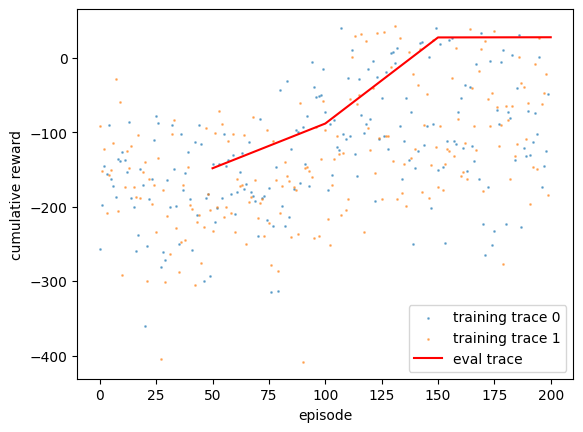

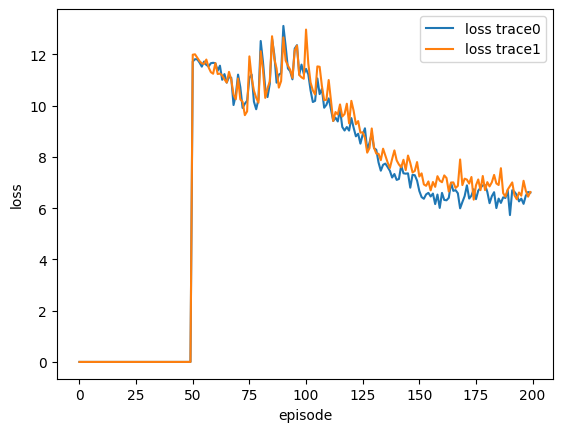

In [ ]:
options = {
    "update_episodes": 5,  # target update rate : (fully) update the target network every 5 episodes
    "learning_rate": 5e-3,  # learning rate : 5 · 10−3 (when the action-space is binary)
    "discount_factor": .9,
    "buffer_size": 2e4,
    "batch_size": 2048,
    "epsilon": .7,
    "savepath": "models/agentDQN_no_decreasing_exploration.pt"
}

agentDQN1, _, _, _ = training(train_constant_exploration, AgentDQN, iterations=300, epochs=3, options=options)

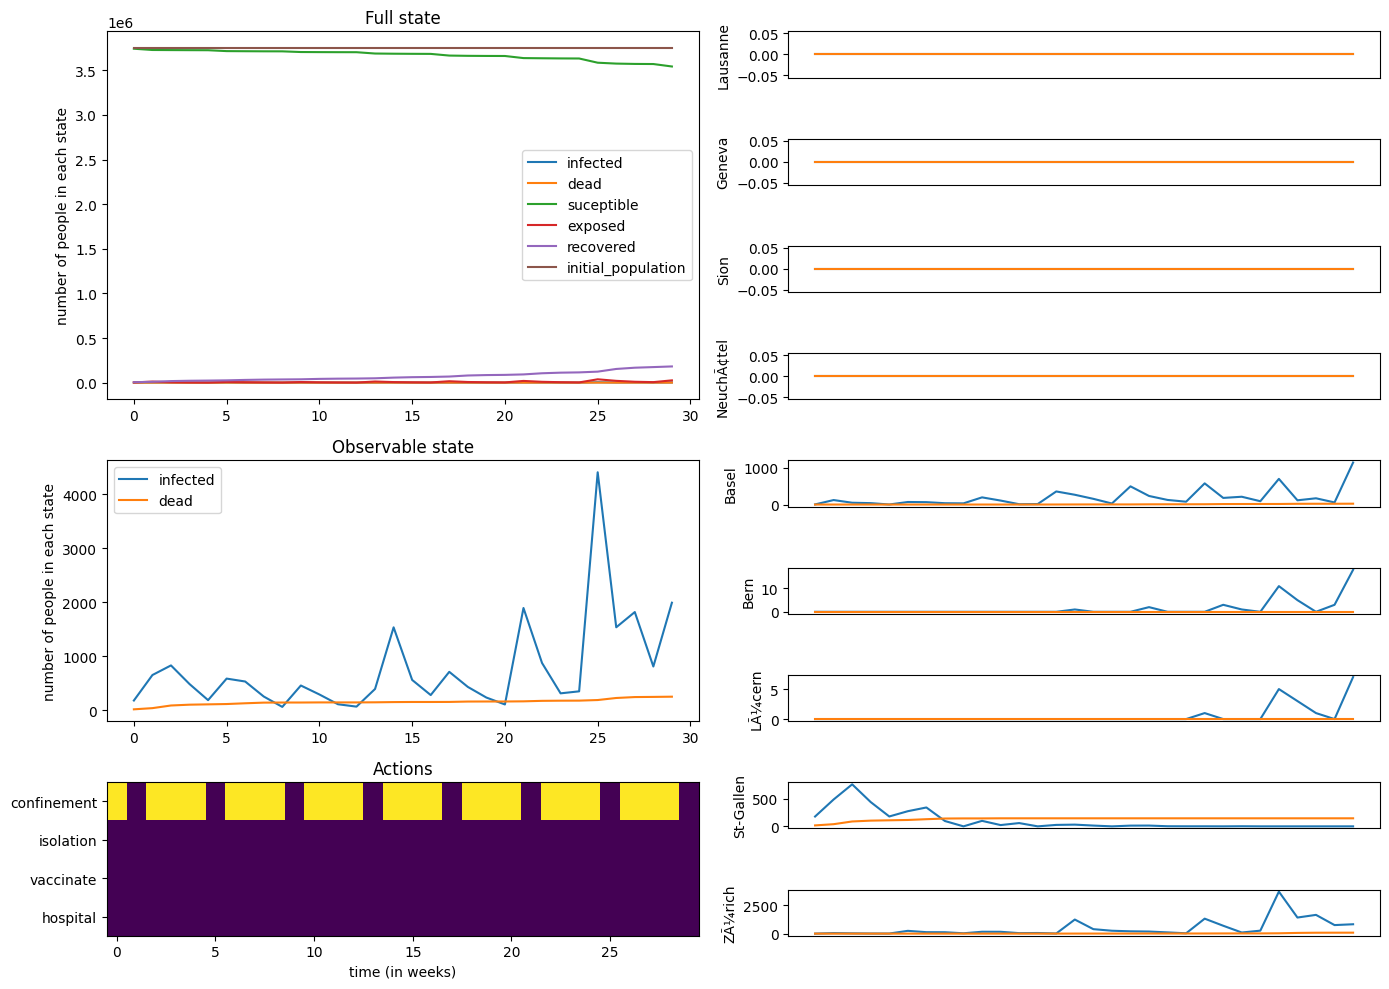

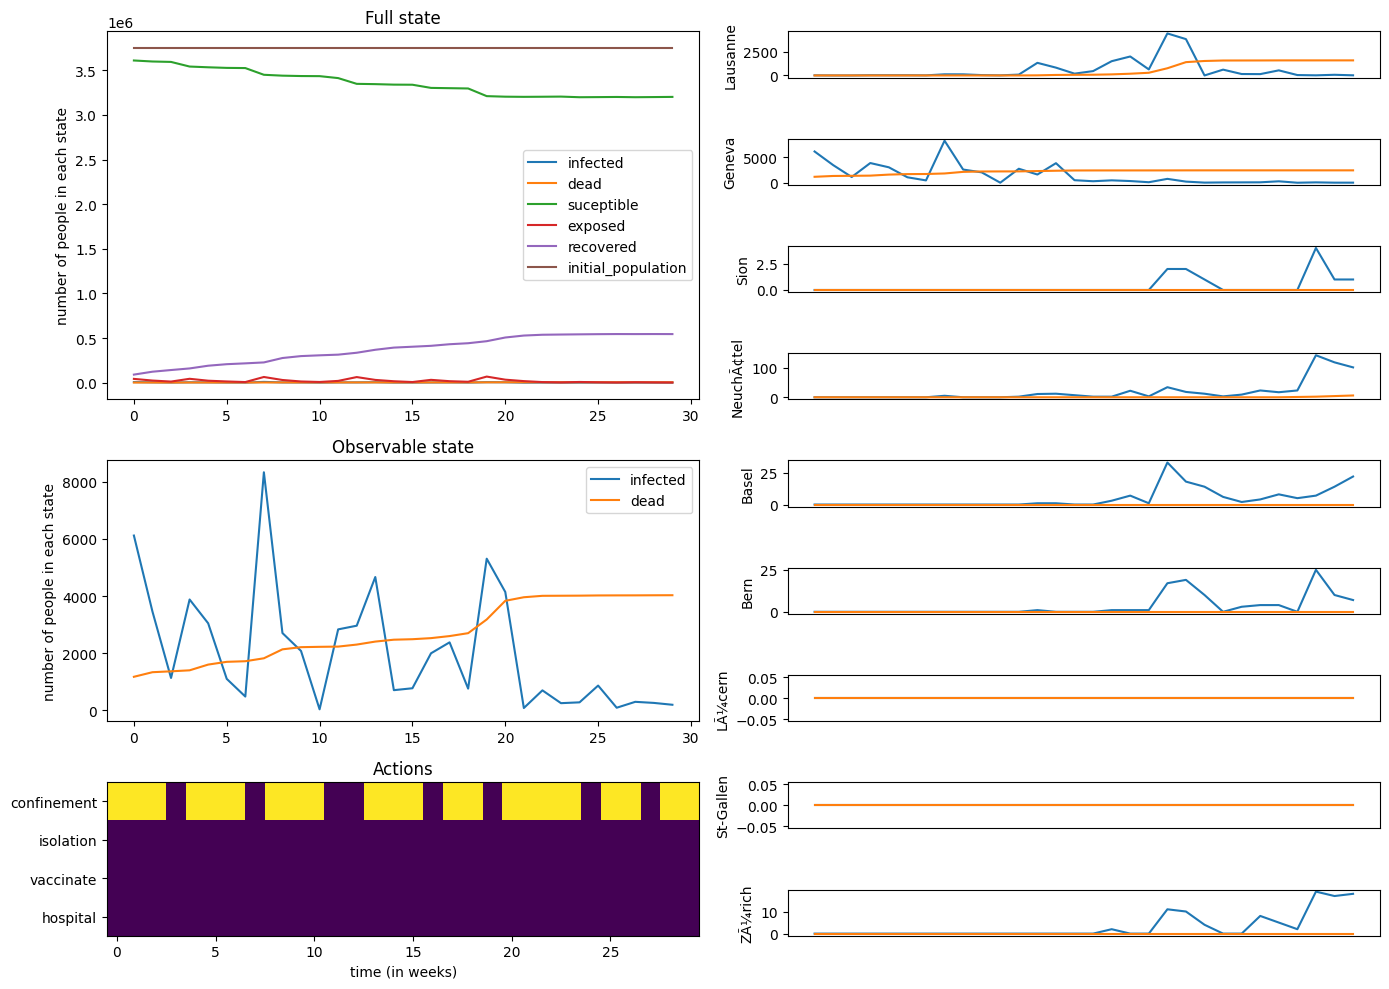

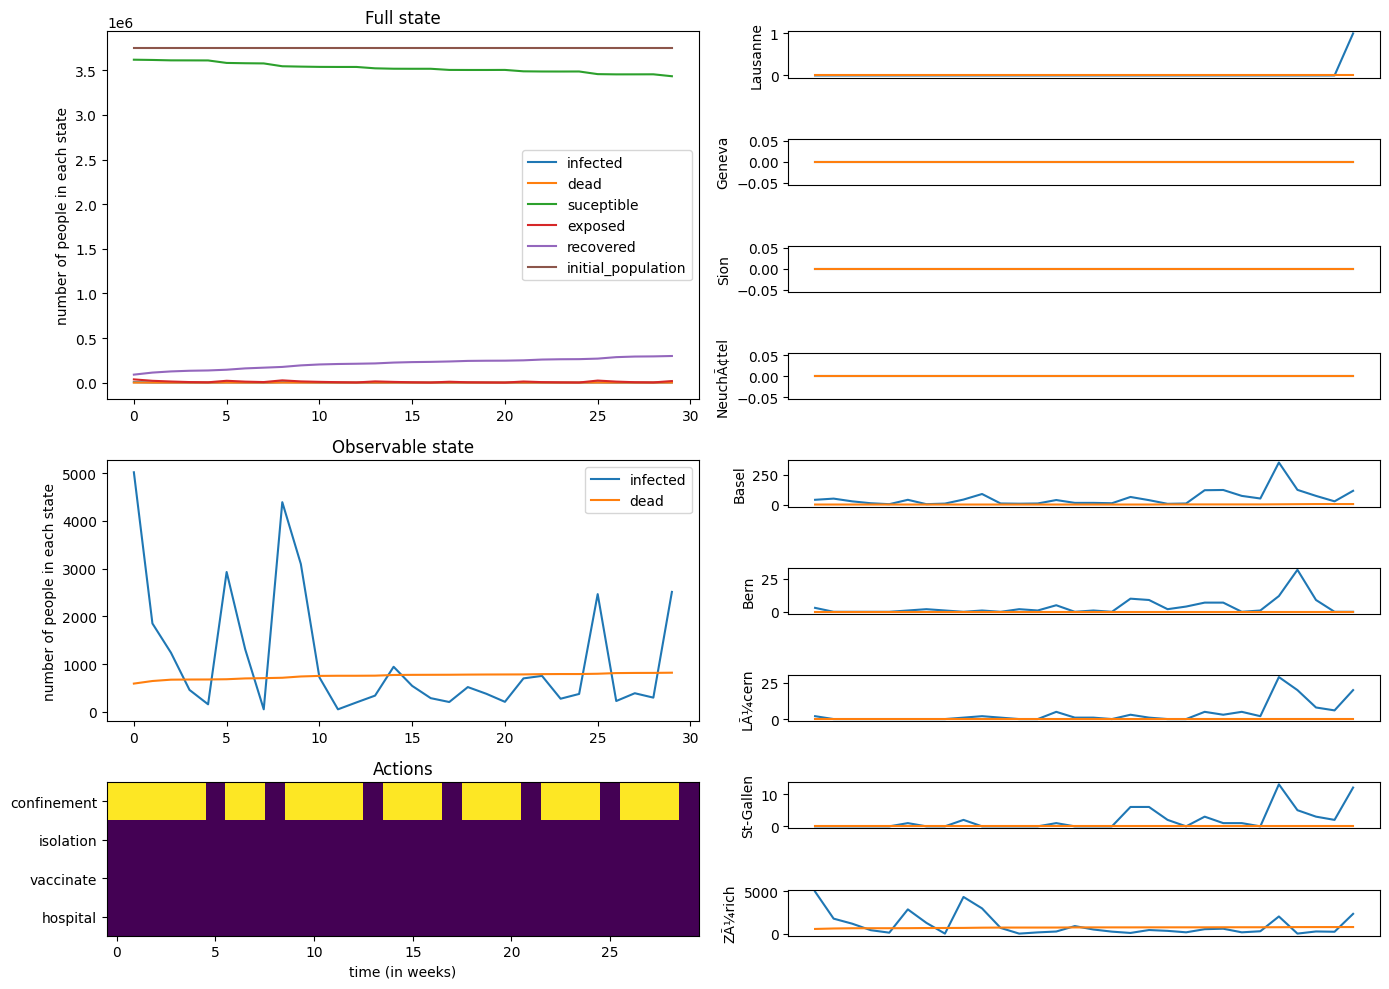

In [ ]:
# Plot 3 episodes of the best agent
agentDQN1 = AgentDQN()
agentDQN1.load_model('models/agentDQN_no_decreasing_exploration.pt')

for i in range(3):
    obs, reward = env.reset(seed=i)
    infos_list = []

    agentDQN1.reset()
    for i in range(30):
        obs, reward, done, info = env.step(agentDQN1.act(obs, reward))
        infos_list.append(info)
        
    plot_results(*parse_infos(infos_list))

### Question 3.b)

In [ ]:
def train_decreasing_exploration(policy: Agent, env: Env, iterations: int, savepath: str = None, eps_0: float = .7, eps_min: float = .2,
                                 *args, **kwargs):
    """
    redefine the train function to update epsilon at each iteration
    """

    eval_trace, training_trace, loss_trace = [], [], []

    for i in range(iterations):
        # update epsilon
        policy.epsilon = max(eps_0 * (iterations - i) / iterations, eps_min)

        # Run an episode.
        action_list, obs_list, cumulated_reward = run_episode(policy, env, weeks=30, seed=i)

        # Log the cumuative reward to training trace
        training_trace.append(cumulated_reward.item())

        # run a training step :
        loss_trace.append(policy.optimize_model())

        if (i + 1) % 50 == 0:
            old_epsilon = policy.epsilon
            policy.epsilon = 0
            _, cumulated_reward_list, _ = evaluate_policy(policy, env, 20)
            policy.epsilon = old_epsilon

            # Compute the average cumulative reward over the 20 evaluation episodes and log it to eval trace.
            average_cumulated_reward = sum(cumulated_reward_list) / len(cumulated_reward_list)
            eval_trace.append(average_cumulated_reward.item())

            # print the average cumulative reward
            print(f'Checkpoint {i // 50 + 1} : average cumulated reward = {average_cumulated_reward}')

             # saving the model if it performs better
            if average_cumulated_reward > policy.best_eval_reward:
                if savepath is not None:
                    print(f'-- Saving model --')
                    policy.save_model(savepath=savepath)
                    policy.best_eval_reward = average_cumulated_reward

    return eval_trace, training_trace, loss_trace

In [ ]:
options = {
    "update_episodes": 5,  # target update rate : (fully) update the target network every 5 episodes
    "learning_rate": 5e-3,  # learning rate : 5 · 10−3 (when the action-space is binary)
    "discount_factor": .9,
    "buffer_size": 2e4,
    "batch_size": 2048,
    "epsilon": .7,
    "eps_min": .2,
    "eps_0": .7,
    "savepath": "models/agentDQN_decreasing_exploration.pt"
}

agentDQN2, _, _, _ = training(train_decreasing_exploration, AgentDQN, iterations=500, epochs=3, options=options)

In [ ]:
# Plot 3 episodes of the best agent
agentDQN2 = AgentDQN()
agentDQN2.load_model('models/agentDQN_decreasing_exploration.pt')

for i in range(3):
    obs, reward = env.reset(seed=i)
    infos_list = []

    agentDQN2.reset()
    for i in range(30):
        obs, reward, done, info = env.step(agentDQN2.act(obs, reward))
        infos_list.append(info)

    plot_results(*parse_infos(infos_list))

### Question 3.c)

In [ ]:
# Plot the DQN1 evaluation histogram
agentDQN1 = AgentDQN()
agentDQN1.load_model('models/agentDQN_no_decreasing_exploration.pt')

number_of_confined_days, cumulative_reward, number_of_total_deaths = evaluate_policy(agentDQN1, env)
plot_histogram(number_of_confined_days, cumulative_reward, number_of_total_deaths)

In [ ]:
# Plot the DQN2 evaluation histogram
agentDQN2 = AgentDQN()
agentDQN2.load_model('models/agentDQN_decreasing_exploration.pt')

number_of_confined_days, cumulative_reward, number_of_total_deaths = evaluate_policy(agentDQN2, env)
plot_histogram(number_of_confined_days, cumulative_reward, number_of_total_deaths)

# Question 4

## Question 4.1)

### Question 4.1.b)

In [73]:
class AgentDQNToggleAction(Agent):
    """
    Implemented by following this tutorial : https://pytorch.org/tutorials/intermediate/reinforcement_q_learning.html
    """
    confinement = False
    vaccinate = False
    isolation = False
    hospital = False

    def __init__(self,
                 update_episodes: int = 5,
                 learning_rate: float = 5e-3,
                 discount_factor: float = .9,
                 buffer_size: int = 2e4,
                 batch_size: int = 2048,
                 epsilon: float = 0,
                 seed: int = 0,
                 best_eval_reward: float = -float('inf'),
                 *args,
                 **kwargs):

        # set the seed for reproducibility
        torch.manual_seed(seed)
        if torch.cuda.is_available():
            torch.cuda.manual_seed_all(seed)
        torch.use_deterministic_algorithms(False)

        self.update_episodes = update_episodes
        self.learning_rate = learning_rate
        self.discount_factor = discount_factor
        self.buffer_size = buffer_size
        self.batch_size = batch_size
        self.epsilon = epsilon

        self.episode = 0
        self.buffer = []  # contains (states, actions, next_state, reward) tuples
        self.last_obs, self.last_action, self.last_reward = None, None, None

        in_dim, out_dim = 2 * 9 * 7, 5
        self.Q_network = create_model(in_dim, out_dim, nn.ReLU())
        self.Q_target_network = create_model(in_dim, out_dim, nn.ReLU())
        self.optimizer = torch.optim.AdamW(self.Q_network.parameters(), lr=self.learning_rate, amsgrad=True)

        self.best_eval_reward = best_eval_reward  # for model saving

    def load_model(self, savepath: str):
        self.Q_network.load_state_dict(torch.load(savepath))
        # load the target network with the same weights
        self.Q_target_network.load_state_dict(self.Q_network.state_dict())

    def optimize_model(self) -> float:
        if len(self.buffer) < self.batch_size:
            return 0
        transitions = torch.randperm(len(self.buffer))[:self.batch_size]
        transitions = [self.buffer[i] for i in transitions]
        state_batch, action_batch, next_state_batch, reward_batch = zip(*transitions)
        state_batch, reward_batch = map(torch.stack, (state_batch, reward_batch))
        action_batch = torch.tensor(action_batch).reshape(-1, 1).to(device)
        state_batch = state_batch.to(device)
        reward_batch = reward_batch.reshape((-1, 1)).to(device)  # reshape to (batch_size, 1)

        next_state_batch = [obs for obs in next_state_batch if obs is not None]

        # Compute Q(s_t, a) - the model computes Q(s_t), then we select the columns of actions taken.
        state_action_values = self.Q_network(state_batch).gather(1, action_batch)

        # Compute V(s_{t+1}) for all next states.
        next_state_values = torch.zeros(self.batch_size, device=device)
        with torch.no_grad():
            if len(next_state_batch) > 0:
                non_final_mask = torch.tensor(tuple(map(lambda t: t[2] is not None, transitions)), device=device,
                                              dtype=torch.bool)
                next_state_batch = torch.stack(next_state_batch).to(device)
                next_state_values[non_final_mask] = self.Q_target_network(next_state_batch).max(1)[0]

        next_state_values = next_state_values.reshape((-1, 1))

        # Compute the expected Q values
        expected_state_action_values = (next_state_values * self.discount_factor) + reward_batch

        # Compute Huber loss
        criterion = nn.SmoothL1Loss()
        loss = criterion(state_action_values, expected_state_action_values)

        # Optimize the model
        self.optimizer.zero_grad()
        loss.backward()
        self.optimizer.step()

        # update the target network every update_episode steps
        if self.episode % self.update_episodes == 0:
            self.Q_target_network.load_state_dict(self.Q_network.state_dict())

        # do not do in place gradient clipping
        return loss.item()

    def save_model(self, savepath: str):
        torch.save(self.Q_network.state_dict(), savepath)

    def reset(self):
        """
        Called at the beginning of each episode
        """
        if self.last_reward is not None:
            self.buffer.append((self.last_obs, self.last_action, None, self.last_reward))
        self.last_reward = None
        self.last_obs = None
        self.last_action = None
        self.episode += 1

    def act(self, obs, reward):
        # cast the observation
        obs = observation2tensor(obs)
        # get the next action
        # epsilon-greedy policy
        if torch.rand(1) < self.epsilon:
            action = torch.rand(5).to(device)
        else:
            with torch.no_grad():
                action = self.Q_network(obs)

        action = torch.argmax(action)
        if self.last_obs is not None and self.last_action is not None:
            # store the transition
            self.buffer.append((self.last_obs, self.last_action, obs, reward))

        self.last_action = action
        self.last_obs = obs
        self.last_reward = reward
        if len(self.buffer) > self.buffer_size:
            self.buffer.pop(0)
        # return next action
        action = [
            'do nothing',
            'toggle confinement',
            'toggle isolation',
            'toggle additional hospital beds',
            'toggle vaccination'
        ][action]
        # return next action
        toggle_confinement = action == 'toggle confinement'
        toggle_isolation = action == 'toggle isolation'
        toggle_hospital = action == 'toggle additional hospital beds'
        toggle_vaccinate = action == 'toggle vaccination'
        self.confinement = toggle_confinement ^ self.confinement
        self.isolation = toggle_isolation ^ self.isolation
        self.hospital = toggle_hospital ^ self.hospital
        self.vaccinate = toggle_vaccinate ^ self.vaccinate
        return {
            'confinement': self.confinement,
            'isolation': self.isolation,
            'hospital': self.hospital,
            'vaccinate': self.vaccinate
        }

In [74]:
options = {
    "update_episodes": 5,  # target update rate : (fully) update the target network every 5 episodes
    "learning_rate": 1e-5,  # learning rate : 10−5 (when the action-space is more complexe than binary)
    "discount_factor": .9,
    "buffer_size": 2e4,
    "batch_size": 2048,
    "epsilon": .7,
    "eps_min": .2,
    "eps_0": .7,
    "savepath": "models/agentDQN_toggle_action.pt"
}

agentDQNToggleAction, training_traces_toggle, eval_trace_toggle, loss_traces_toggle  = training(train_decreasing_exploration, AgentDQNToggleAction, iterations=500, epochs=3,
                                options=options)

--------------------
Epoch 1
Checkpoint 1 : average cumulated reward = 43.60945510864258
-- Saving model --
Checkpoint 2 : average cumulated reward = -150.52401733398438
Checkpoint 3 : average cumulated reward = -20.720678329467773
Checkpoint 4 : average cumulated reward = -12.323452949523926
Checkpoint 5 : average cumulated reward = 14.965576171875
Checkpoint 6 : average cumulated reward = 17.360200881958008
Checkpoint 7 : average cumulated reward = -11.728675842285156
Checkpoint 8 : average cumulated reward = -6.323453903198242
Checkpoint 9 : average cumulated reward = -8.302957534790039
Checkpoint 10 : average cumulated reward = -39.7286376953125
--------------------
Epoch 2


In [ ]:
# Run 3 episodes of the best agent
agentDQNToggleAction = AgentDQNToggleAction()
agentDQNToggleAction.load_model("models/agentDQN_toggle_action.pt")

for i in range(3):
    obs, reward = env.reset(seed=i)
    infos_list = []

    agentDQNToggleAction.reset()
    for i in range(30):
        obs, reward, done, info = env.step(agentDQNToggleAction.act(obs, reward))
        infos_list.append(info)

    plot_results(*parse_infos(infos_list))

### Question 4.1.c)

In [ ]:
# Plot the evaluation histogram
agentDQNToggleAction = AgentDQNToggleAction()
agentDQNToggleAction.load_model("models/agentDQN_toggle_action.pt")

number_of_confined_days, cumulative_reward, number_of_total_deaths = evaluate_policy(agentDQNToggleAction, env)
plot_histogram(number_of_confined_days, cumulative_reward, number_of_total_deaths)

## Question 4.2)

### Question 4.2.a)

In [63]:
class AgentDQNFactorized(Agent):
    """
    Implemented by following this tutorial : https://pytorch.org/tutorials/intermediate/reinforcement_q_learning.html
    """

    def __init__(self,
                 update_episodes: int = 5,
                 learning_rate: float = 5e-3,
                 discount_factor: float = .9,
                 buffer_size: int = 2e4,
                 batch_size: int = 2048,
                 epsilon: float = 0,
                 seed: int = 0,
                 best_eval_reward: float = -float('inf'),
                 *args,
                 **kwargs):
        # set the seed for reproducibility
        torch.manual_seed(seed)
        if torch.cuda.is_available():
            torch.cuda.manual_seed_all(seed)
        torch.use_deterministic_algorithms(False)

        self.update_episodes = update_episodes
        self.learning_rate = learning_rate
        self.discount_factor = discount_factor
        self.buffer_size = buffer_size
        self.batch_size = batch_size
        self.epsilon = epsilon

        self.episode = 0
        self.buffer = []  # contains (states, actions, next_state, reward) tuples
        self.last_obs, self.last_action, self.last_reward = None, None, None

        in_dim, out_dim = 2 * 9 * 7, 4 * 2
        self.Q_network = create_model(in_dim, out_dim, nn.ReLU())
        self.Q_target_network = create_model(in_dim, out_dim, nn.ReLU())
        self.optimizer = torch.optim.AdamW(self.Q_network.parameters(), lr=self.learning_rate, amsgrad=True)

        self.best_eval_reward = best_eval_reward  # for model saving

    def load_model(self, savepath: str):
        self.Q_network.load_state_dict(torch.load(savepath))
        # load the target network with the same weights
        self.Q_target_network.load_state_dict(self.Q_network.state_dict())

    def optimize_model(self) -> float:
        if len(self.buffer) < self.batch_size:
            return 0
        transitions = torch.randperm(len(self.buffer))[:self.batch_size]
        transitions = [self.buffer[i] for i in transitions]
        state_batch, action_batch, next_state_batch, reward_batch = zip(*transitions)
        state_batch, reward_batch = map(torch.stack, (state_batch, reward_batch))
        action_batch = torch.stack(action_batch).reshape((-1, 4, 1)).to(device)
        state_batch = state_batch.to(device)
        reward_batch = reward_batch.reshape((-1, 1)).to(device)  # reshape to (batch_size, 1)

        next_state_batch = [obs for obs in next_state_batch if obs is not None]

        # Compute Q(s_t, a) - the model computes Q(s_t), then we select the columns of actions taken.
        state_action_values = self.Q_network(state_batch).reshape((-1, 4, 2)).gather(2, action_batch)

        # Compute V(s_{t+1}) for all next states.
        next_state_values = torch.zeros((self.batch_size, 4), device=device)
        with torch.no_grad():
            if len(next_state_batch) > 0:
                non_final_mask = torch.tensor(tuple(map(lambda t: t[2] is not None, transitions)), device=device,
                                              dtype=torch.bool)
                next_state_batch = torch.stack(next_state_batch).to(device)
                next_state_values[non_final_mask] = self.Q_target_network(next_state_batch).reshape(-1, 4, 2).max(2)[0]

        # Compute the expected Q values
        expected_state_action_values = (next_state_values * self.discount_factor) + reward_batch

        # Compute Huber loss
        state_action_values = state_action_values.reshape((-1, 1))
        expected_state_action_values = expected_state_action_values.reshape((-1, 1))
        criterion = nn.SmoothL1Loss()
        loss = criterion(state_action_values, expected_state_action_values)

        # Optimize the model
        self.optimizer.zero_grad()
        loss.backward()
        self.optimizer.step()

        # update the target network every update_episode steps
        if self.episode % self.update_episodes == 0:
            self.Q_target_network.load_state_dict(self.Q_network.state_dict())

        # do not do in place gradient clipping
        return loss.item()

    def save_model(self, savepath: str):
        torch.save(self.Q_network.state_dict(), savepath)

    def reset(self):
        """
        Called at the beginning of each episode
        """
        if self.last_reward is not None:
            self.buffer.append((self.last_obs, self.last_action, None, self.last_reward))

        self.last_obs = None
        self.last_action = None
        self.last_reward = None
        self.episode += 1

    def act(self, obs, reward):
        # cast the observation
        obs = observation2tensor(obs)
        # get the next action
        # epsilon-greedy policy
        if torch.rand(1) < self.epsilon:
            # Randomly select either True or False for each action
            action = torch.randint(2, (4,)).to(device)
        else:
            with torch.no_grad():
                q_values = self.Q_network(obs).reshape((4, 2))
                action = torch.argmax(q_values, dim=1)
        
        if self.last_obs is not None and self.last_action is not None:
            # store the transition
            self.buffer.append((self.last_obs, self.last_action, obs, reward))

        self.last_action = action
        self.last_obs = obs
        self.last_reward = reward
        if len(self.buffer) > self.buffer_size:
            self.buffer.pop(0)
        # return next action
        return {
            'confinement': bool(action[0]),
            'isolation': bool(action[1]),
            'hospital': bool(action[2]),
            'vaccinate': bool(action[3])
        }

--------------------
Epoch 1
Checkpoint 1 : average cumulated reward = -150.52401733398438
-- Saving model --
Checkpoint 2 : average cumulated reward = -150.52401733398438
Checkpoint 3 : average cumulated reward = -150.52401733398438
Checkpoint 4 : average cumulated reward = -150.52401733398438
Checkpoint 5 : average cumulated reward = -150.52401733398438
Checkpoint 6 : average cumulated reward = -150.52401733398438
Checkpoint 7 : average cumulated reward = -150.52401733398438
Checkpoint 8 : average cumulated reward = -150.52401733398438
Checkpoint 9 : average cumulated reward = -150.52401733398438
Checkpoint 10 : average cumulated reward = -150.52401733398438
--------------------
Epoch 2
Checkpoint 1 : average cumulated reward = 23.360198974609375
-- Saving model --
Checkpoint 2 : average cumulated reward = 23.360198974609375
Checkpoint 3 : average cumulated reward = 23.360198974609375
Checkpoint 4 : average cumulated reward = 23.360198974609375
Checkpoint 5 : average cumulated reward

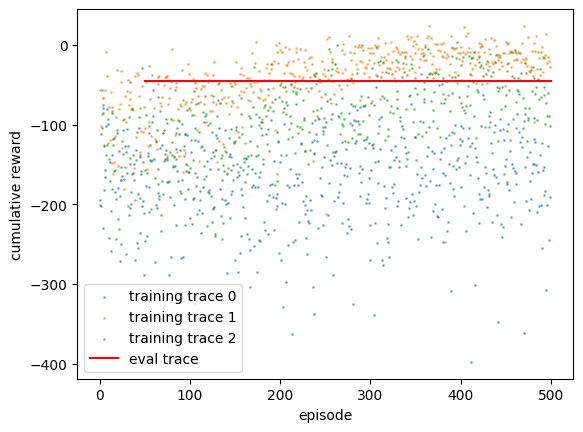

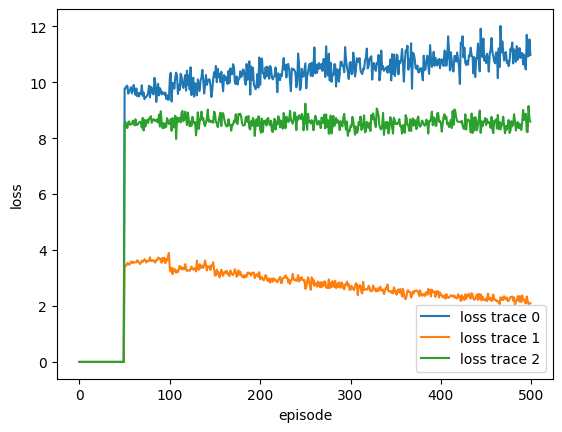

In [64]:
options = {
    "update_episodes": 5,  # target update rate : (fully) update the target network every 5 episodes
    "learning_rate": 1e-5,  # learning rate : 10−5 (when the action-space is more complexe than binary)
    "discount_factor": .9,
    "buffer_size": 2e4,
    "batch_size": 2048,
    "epsilon": .7,
    "eps_min": .2,
    "eps_0": .7,
    "savepath": "models/agentDQN_factorized.pt"
}

agentDQNFactorized, training_traces_factorized, eval_trace_factorized, loss_traces_factorized = training(train_decreasing_exploration, AgentDQNFactorized, iterations=500, epochs=3,
                              options=options)

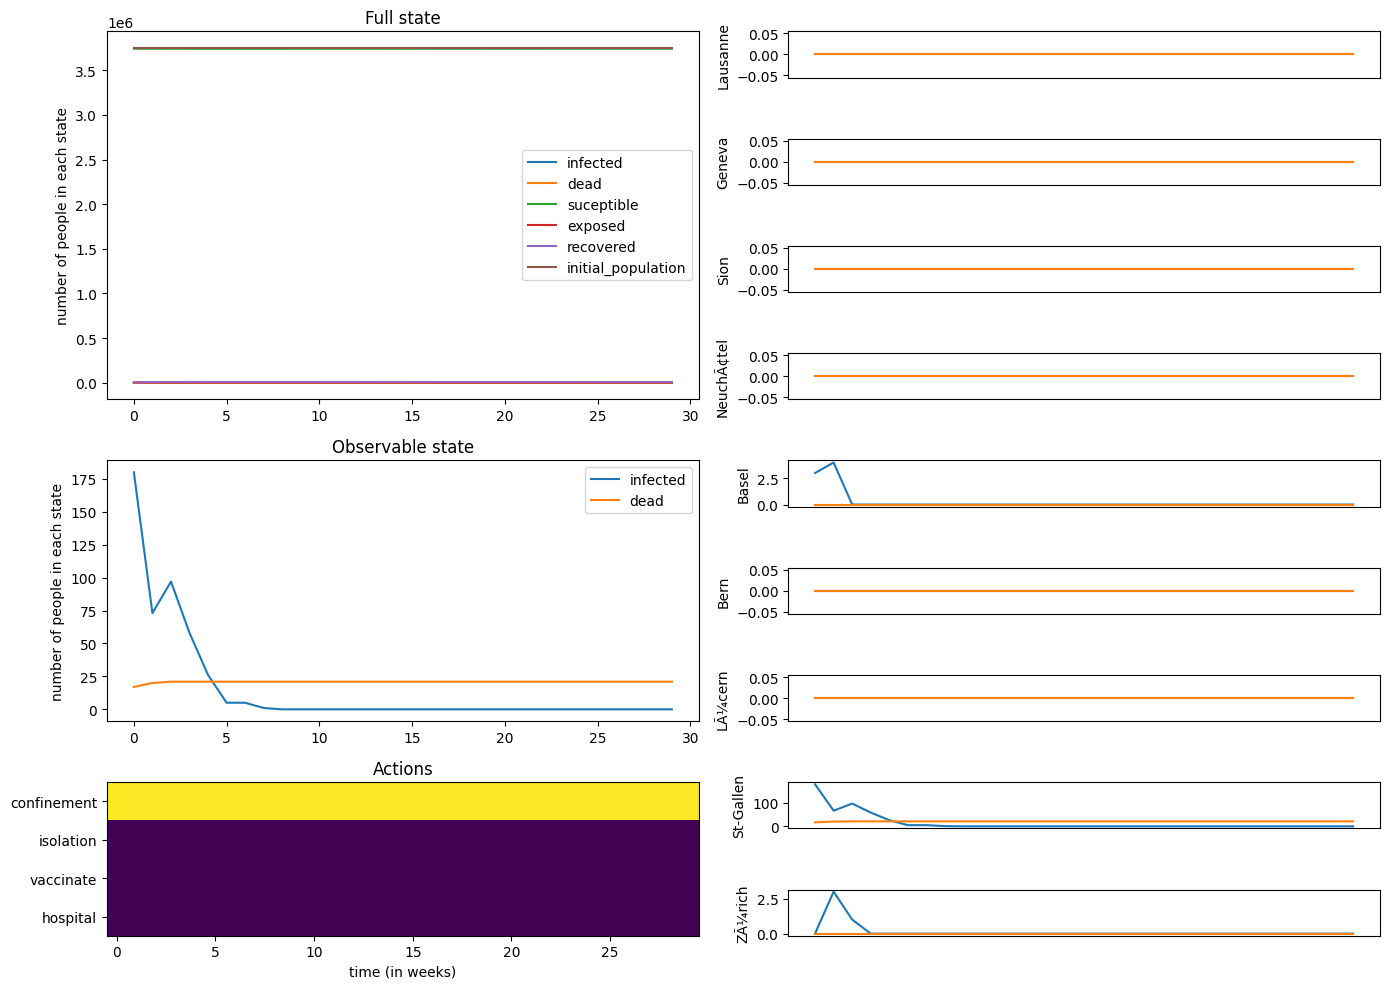

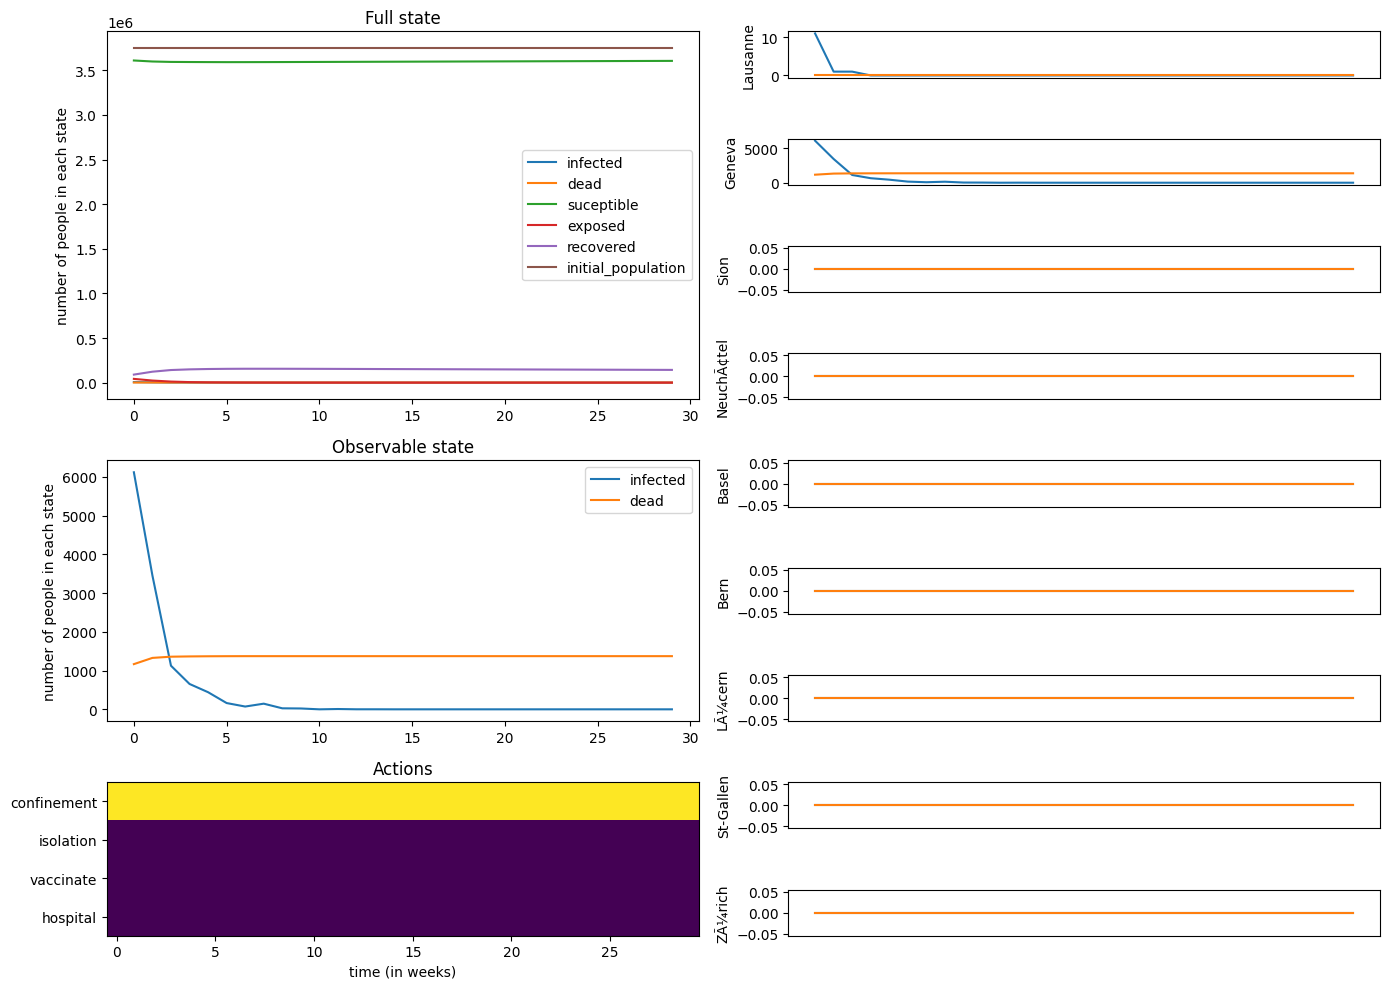

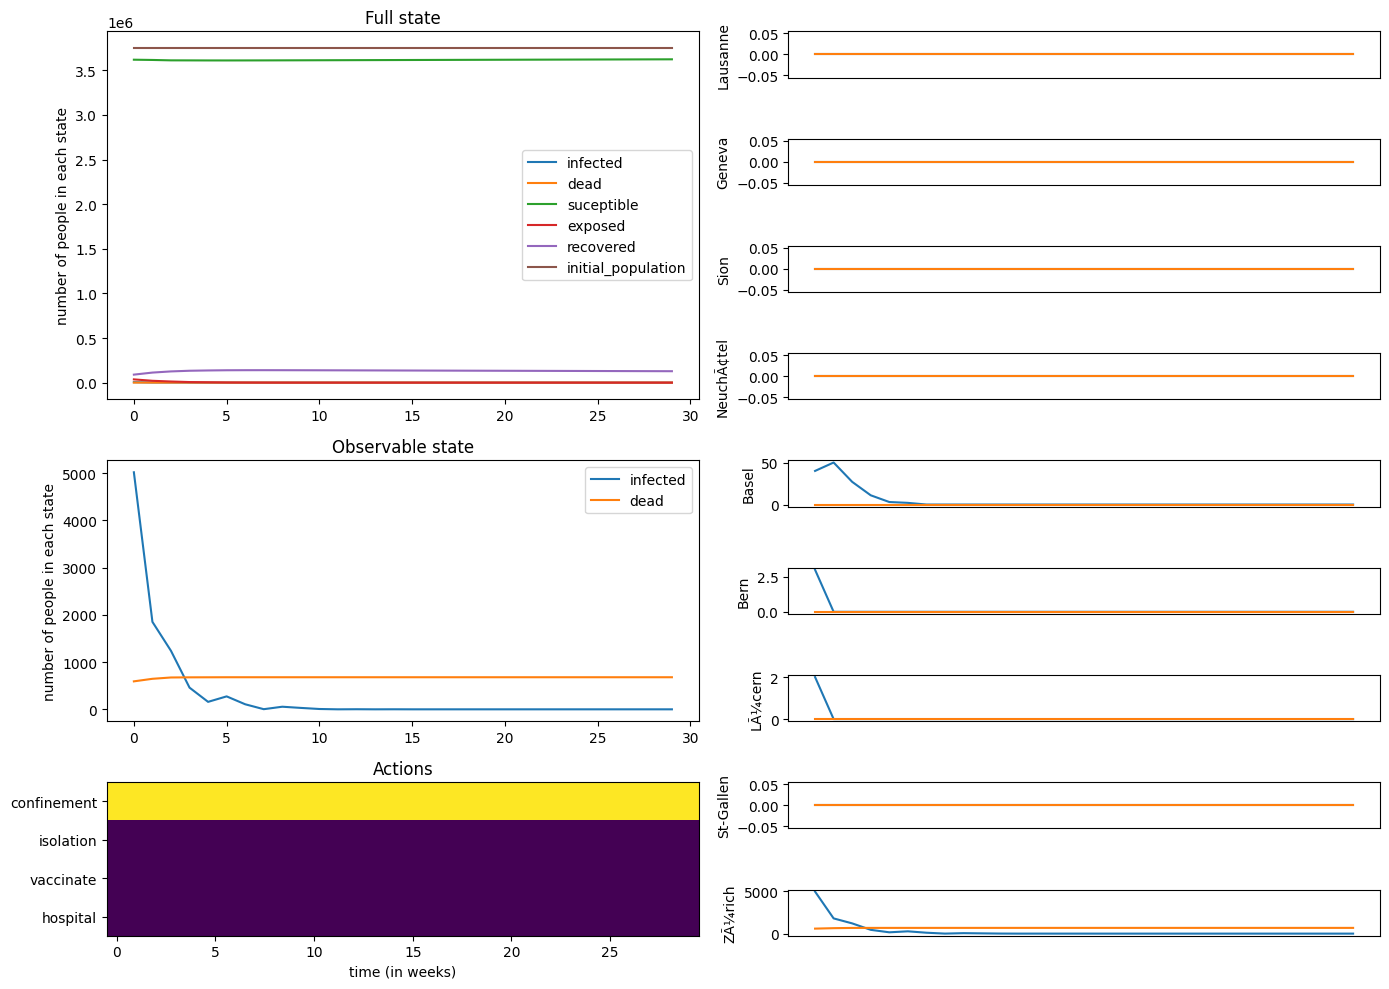

In [71]:
# Run 3 episodes of the best agent
agentDQNFactorized = AgentDQNFactorized()
agentDQNFactorized.load_model("models/agentDQN_factorized.pt")

for i in range(3):
    obs, reward = env.reset(seed=i)
    infos_list = []

    agentDQNFactorized.reset()
    for i in range(30):
        action = agentDQNFactorized.act(obs, reward)
        obs, reward, done, info = env.step(action)
        infos_list.append(info)

    plot_results(*parse_infos(infos_list))

### Question 4.2.b)

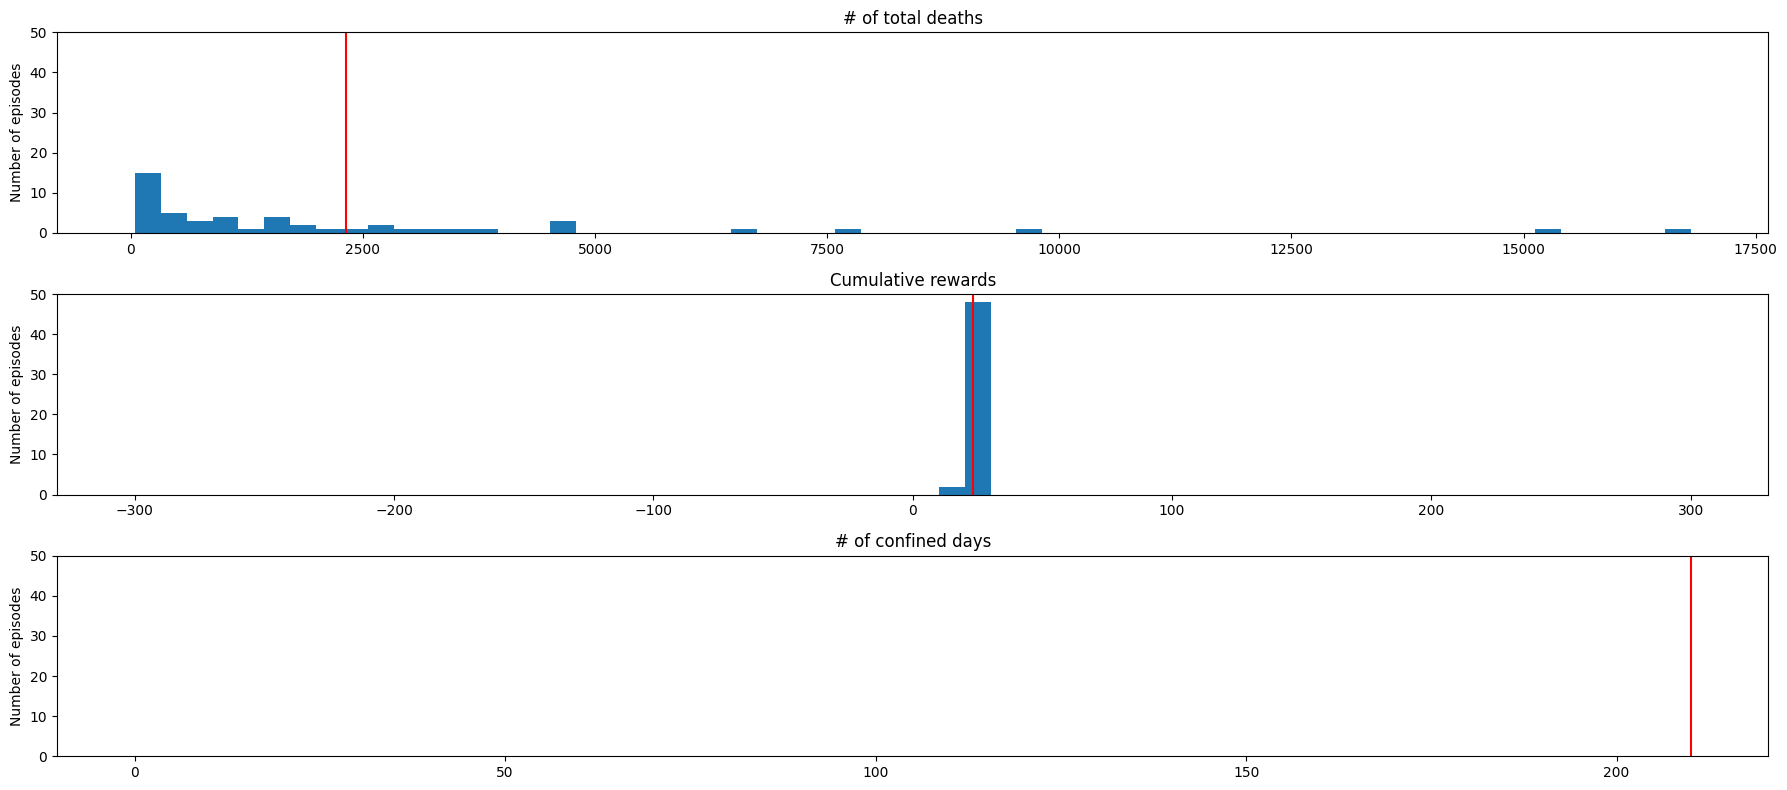

In [72]:
# Plot the evaluation histogram
agentDQNFactorized = AgentDQNFactorized()
agentDQNFactorized.load_model("models/agentDQN_factorized.pt")

number_of_confined_days, cumulative_reward, number_of_total_deaths = evaluate_policy(agentDQNFactorized, env)
plot_histogram(number_of_confined_days, cumulative_reward, number_of_total_deaths)